In [1]:
import bayesnewton
import objax
from jax import vmap
import numpy as np
import matplotlib.pyplot as plt
import time




In [16]:
def wiggly_time_series_1(x_):
    return np.cos(0.04*x_+0.33*np.pi) * np.sin(0.2*x_)


def wiggly_time_series_2(x_):
    # return np.cos(0.05*x_+0.4*np.pi) * np.sin(0.1*x_)
    # return 2 * wiggly_time_series_1(x_)
    return wiggly_time_series_1(x_)



In [17]:
np.random.seed(123)
N = 1000
# x = np.linspace(-17, 147, num=N)
x = np.concatenate([
    np.linspace(-17, 55, num=N),
    np.linspace(75, 147, num=N)
    ], axis=0)
f1 = wiggly_time_series_1(x)[:, None]
f2 = wiggly_time_series_2(x)[:, None]
f = np.concatenate([f1, f2], axis=1)[..., None]

In [18]:
noise_cov = np.array([[0.2, 0.1], [0.1, 0.3]])
# noise_cov = np.array([[0.1, 0.05], [0.05, 0.2]])

noise = np.linalg.cholesky(noise_cov)[None] @ np.random.multivariate_normal(np.zeros(2), np.eye(2), f.shape[0])[..., None]
y = f + noise


In [8]:
y.shape, np.linalg.cholesky(noise_cov)[None].shape, f.shape, np.random.standard_t(3., f.shape).shape

((250, 3, 1), (1, 3, 3), (250, 3, 1), (250, 3, 1))

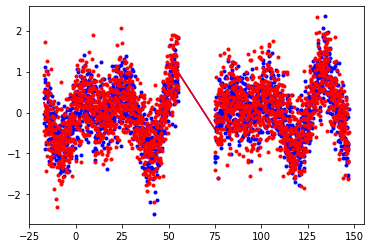

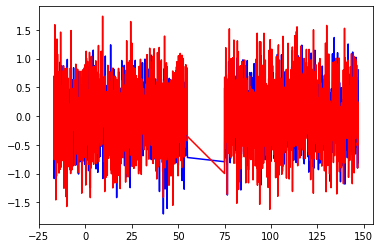

In [20]:
plt.figure(1)
plt.plot(x, f1, 'b-')
plt.plot(x, f2, 'r-')
plt.plot(x, y[:, 0], 'b.')
plt.plot(x, y[:, 1], 'r.')

plt.figure(2)
plt.plot(x, noise[:, 0], 'b')
plt.plot(x, noise[:, 1], 'r')
plt.show()

In [22]:
x_test = np.linspace(np.min(x)-10.0, np.max(x)+10.0, num=500)
f1_test = wiggly_time_series_1(x_test)[:, None]
f2_test = wiggly_time_series_2(x_test)[:, None]
f_test = np.concatenate([f1_test, f2_test], axis=1)[..., None]
noise_test = np.linalg.cholesky(noise_cov)[None] @ np.random.multivariate_normal(np.zeros(2), np.eye(2), f_test.shape[0])[..., None]
y_test = f_test + noise_test
x_plot = np.linspace(np.min(x)-20.0, np.max(x)+20.0, 500)
f1_plot = wiggly_time_series_1(x_plot)
f2_plot = wiggly_time_series_2(x_plot)


In [26]:
x.shape, y.shape, x_plot.shape, noise_cov.shape

((2000,), (2000, 2, 1), (500,), (2, 2))

In [23]:
var_f = 1.0  # GP variance
len_f = 15.0  # GP lengthscale

kern1 = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
kern2 = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
kern = bayesnewton.kernels.Independent(kernels=[kern1, kern2])
lik = bayesnewton.likelihoods.GaussianMultivariate(covariance=noise_cov)

# model = bayesnewton.models.MarkovNewtonGP(kernel=kern, likelihood=lik, X=x, Y=y)
model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=x, Y=y)
# model = bayesnewton.models.MarkovExpectationPropagationGP(kernel=kern, likelihood=lik, X=x, Y=y, power=0.5)
# -- Gauss-Newton ---
# model = bayesnewton.models.MarkovGaussNewtonGP(kernel=kern, likelihood=lik, X=x, Y=y)
# model = bayesnewton.models.MarkovVariationalGaussNewtonGP(kernel=kern, likelihood=lik, X=x, Y=y)
# -- quasi-Newton ---
# model = bayesnewton.models.MarkovQuasiNewtonGP(kernel=kern, likelihood=lik, X=x, Y=y)
# model = bayesnewton.models.MarkovVariationalQuasiNewtonGP(kernel=kern, likelihood=lik, X=x, Y=y)
# model = bayesnewton.models.MarkovExpectationPropagationQuasiNewtonGP(kernel=kern, likelihood=lik, X=x, Y=y, power=0.5)
# --- Riemannian grads ---
# model = bayesnewton.models.MarkovVariationalRiemannGP(kernel=kern, likelihood=lik, X=x, Y=y)

In [28]:
lr_adam = 0.1
lr_newton = 1.
iters = 10
opt_hypers = objax.optimizer.Adam(model.vars())
energy = objax.GradValues(model.energy, model.vars())


@objax.Function.with_vars(model.vars() + opt_hypers.vars())
def train_op():
    model.inference(lr=lr_newton)  # perform inference and update variational params
    dE, E = energy()  # compute energy and its gradients w.r.t. hypers
    # opt_hypers(lr_adam, dE)
    return E


train_op = objax.Jit(train_op)

t0 = time.time()
for i in range(1, iters + 1):
    loss = train_op()
    print('iter %2d, energy: %1.4f' % (i, loss[0]))
t1 = time.time()
print('optimisation time: %2.2f secs' % (t1-t0))


iter  1, energy: 2762.8388
iter  2, energy: 2762.4832
iter  3, energy: 2762.3301
iter  4, energy: 2762.2049
iter  5, energy: 2762.1503
iter  6, energy: 2762.1051
iter  7, energy: 2762.0853
iter  8, energy: 2762.0687
iter  9, energy: 2762.0614
iter 10, energy: 2762.0553
optimisation time: 4.74 secs


In [29]:
t0 = time.time()
posterior_mean, posterior_cov = model.predict_y(X=x_plot)
nlpd = model.negative_log_predictive_density(X=x_test, Y=y_test)
t1 = time.time()

In [31]:
x_plot.shape, x_test.shape, y_test.shape

((500,), (500,), (500, 2, 1))

In [32]:

print('prediction time: %2.2f secs' % (t1-t0))
print('nlpd: %2.3f' % nlpd)
posterior_var = bayesnewton.utils.diag(posterior_cov)
lb = posterior_mean - 1.96 * posterior_var ** 0.5
ub = posterior_mean + 1.96 * posterior_var ** 0.5

prediction time: 3.67 secs
nlpd: 1.489


plotting ...


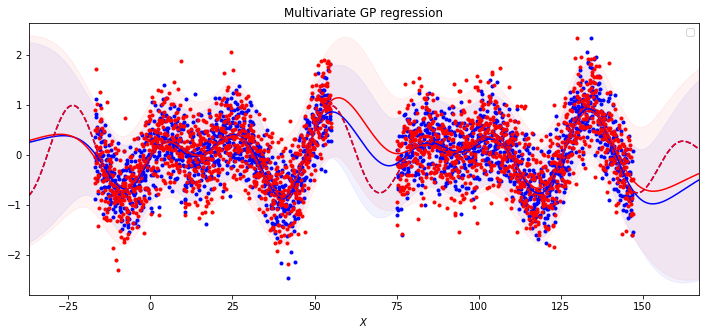

In [35]:
print('plotting ...')
plt.figure(1, figsize=(12, 5))
plt.clf()
plt.plot(x, y[:, 0], 'b.')
plt.plot(x, y[:, 1], 'r.')
# plt.plot(x_test, y_test, 'r.', alpha=0.4, label='test observations')
plt.plot(x_plot, posterior_mean[:, 0], 'b')
plt.plot(x_plot, posterior_mean[:, 1], 'r')
plt.plot(x_plot, f1_plot, 'b--')
plt.plot(x_plot, f2_plot, 'r--')
plt.fill_between(x_plot, lb[:, 0], ub[:, 0], color='b', alpha=0.05)
plt.fill_between(x_plot, lb[:, 1], ub[:, 1], color='r', alpha=0.05)
plt.xlim([x_plot[0], x_plot[-1]])
plt.legend()
plt.title('Multivariate GP regression')
plt.xlabel('$X$')
plt.show()